In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("EDA").getOrCreate()

daily_rideshare = spark.read.csv("../data/curated/daily_rideshare.csv", header=True, inferSchema=True)
daily_weather = spark.read.csv("../data/daily_weather.csv", header=True, inferSchema=True)

hourly_rideshare = spark.read.csv("../data/curated/pickup_hourly_demand.csv", header=True, inferSchema=True)
hourly_weather = spark.read.csv("../data/curated/hourly_weather.csv", header=True, inferSchema=True)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/25 10:09:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/08/25 10:09:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/08/25 10:09:18 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
daily_rideshare.show(5)
daily_weather.show(5)

+-----------+------+
|pickup_date| count|
+-----------+------+
| 2023-08-01|536781|
| 2023-08-02|559686|
| 2023-08-03|588238|
| 2023-08-04|630750|
| 2023-08-05|684196|
+-----------+------+
only showing top 5 rows

+----------+------------------+------------------+------------------+------------------+
|      date|               wnd|               tmp|               dew|               atm|
+----------+------------------+------------------+------------------+------------------+
|2023-07-01|1.0916666666666666|23.866666666666664|14.570833333333333|1017.0958333333333|
|2023-07-02|1.0875000000000001|24.445833333333336|19.995833333333334|1011.9166666666666|
|2023-07-03|            1.0625|25.929166666666664|           21.2375|1009.5958333333333|
|2023-07-04|0.5166666666666667|24.537499999999998|            21.675|           1011.65|
|2023-07-05|0.6833333333333332| 27.22083333333333|           19.6125|1014.4250000000001|
+----------+------------------+------------------+------------------+-----

In [3]:
daily_rideshare.printSchema()
daily_weather.printSchema()

root
 |-- pickup_date: date (nullable = true)
 |-- count: integer (nullable = true)

root
 |-- date: date (nullable = true)
 |-- wnd: double (nullable = true)
 |-- tmp: double (nullable = true)
 |-- dew: double (nullable = true)
 |-- atm: double (nullable = true)



In [4]:
print(f"Rideshare count: {daily_rideshare.count()} rows, {len(daily_rideshare.columns)} columns")
print(f"Weather count: {daily_weather.count()} rows, {len(daily_weather.columns)} columns")


Rideshare count: 153 rows, 2 columns
Weather count: 184 rows, 5 columns


In [15]:
pandas_daily_rideshare = daily_rideshare.toPandas()
pandas_weather = daily_weather.toPandas()

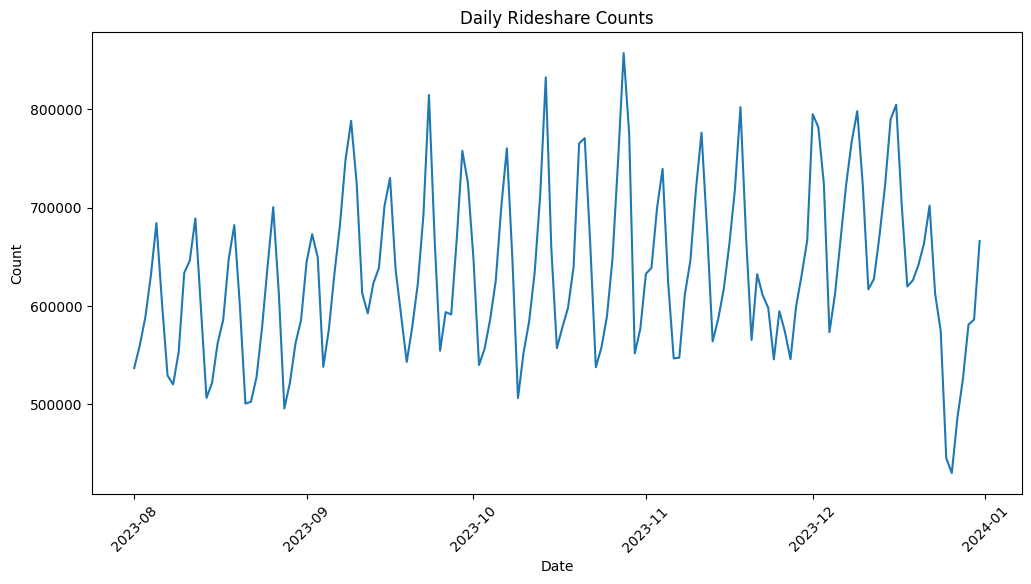

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Rideshare counts over time
plt.figure(figsize=(12, 6))
plt.plot(pandas_rideshare['pickup_date'], pandas_rideshare['count'])
plt.title('Daily Rideshare Counts')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


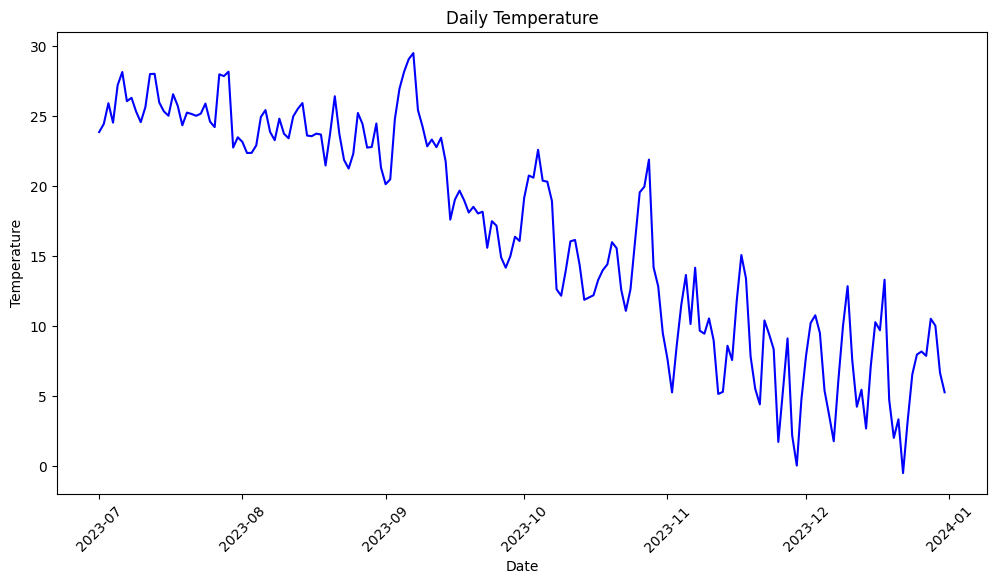

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(pandas_weather['date'], pandas_weather['tmp'], color='blue')
plt.title('Daily Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.show()

In [9]:
import pandas as pd
# Merge the DataFrames on the date columns
merged_df2 = pd.merge(pandas_rideshare, pandas_weather, left_on='pickup_date', right_on='date', how='inner')

# Drop the redundant date column if necessary
merged_df2 = merged_df2.drop(columns=['date'])


# Ensure 'pickup_date' is in datetime format
merged_df2['pickup_date'] = pd.to_datetime(merged_df2['pickup_date'], errors='coerce')

# Now, create the 'is_weekday' column
merged_df2['is_weekday'] = merged_df2['pickup_date'].dt.dayofweek < 5


merged_df2['day_of_week_num'] = merged_df2['pickup_date'].dt.dayofweek
merged_df2

,pickup_date,count,wnd,tmp,dew,atm,is_weekday,day_of_week_num
0,2023-08-01,536781,2.229167,23.162500,10.779167,1018.833333,True,1
1,2023-08-02,559686,1.483333,22.370833,8.695833,1022.416667,True,2
2,2023-08-03,588238,1.270833,22.379167,12.470833,1019.975000,True,3
3,2023-08-04,630750,1.225000,22.912500,16.591667,1014.754167,True,4
4,2023-08-05,684196,1.479167,24.945833,16.837500,1014.208333,False,5
...,...,...,...,...,...,...,...,...
148,2023-12-27,485952,1.687500,7.866667,5.762500,1019.670833,True,2
149,2023-12-28,525887,3.828000,10.520000,8.944000,1006.668000,True,3
150,2023-12-29,580989,1.400000,10.020000,6.976000,1004.560000,True,4
151,2023-12-30,586031,2.725000,6.658333,0.437500,1003.495833,False,5


In [10]:
from pyspark.sql.functions import dayofweek, when, col

merged_df3 = hourly_rideshare.join(
    hourly_weather,
    (hourly_rideshare.pickup_date == hourly_weather.date) & (hourly_rideshare.pickup_hour == hourly_weather.hour),
    'inner'
)

# Drop redundant columns if necessary
merged_df3 = merged_df3.drop('date', 'hour')

# Convert 'pickup_date' to DateType if not already
merged_df3 = merged_df3.withColumn('pickup_date', col('pickup_date').cast('date'))

# Add 'day_of_week' column (1 = Monday, ..., 7 = Sunday)
merged_df3 = merged_df3.withColumn('day_of_week', dayofweek(col('pickup_date')))

# Add 'is_weekday' column (True for weekdays, False for weekends)
merged_df3 = merged_df3.withColumn(
    'is_weekday',
    when(col('day_of_week') < 6, True).otherwise(False)
)
from pyspark.sql.functions import dayofweek, when, col

# Add 'day_of_week' column: 1 = Monday, 7 = Sunday
merged_df3 = merged_df3.withColumn('day_of_week', dayofweek(col('pickup_date')))

# Add 'is_weekday' column: True for weekdays (Monday to Friday), False for weekends (Saturday and Sunday)
merged_df3 = merged_df3.withColumn('is_weekday', when(col('day_of_week') < 6, True).otherwise(False))

# add morning/afternoon boolean
merged_df3 = merged_df3.withColumn('is_morning', when(col('pickup_hour').between(6, 11), True).otherwise(False))

# Show the result
merged_df3.show()

+------------+-----------+-----------+-----+---+----+----+------+-----------+----------+----------+
|pulocationid|pickup_date|pickup_hour|count|wnd| tmp| dew|   atm|day_of_week|is_weekday|is_morning|
+------------+-----------+-----------+-----+---+----+----+------+-----------+----------+----------+
|           3| 2023-08-01|          1|   11|2.1|24.4|12.2|1016.7|          3|      true|     false|
|          33| 2023-08-01|          2|   11|0.0|22.8|12.8|1017.1|          3|      true|     false|
|          26| 2023-08-01|          2|   16|0.0|22.8|12.8|1017.1|          3|      true|     false|
|         173| 2023-08-01|          2|   24|0.0|22.8|12.8|1017.1|          3|      true|     false|
|          52| 2023-08-01|          2|    8|0.0|22.8|12.8|1017.1|          3|      true|     false|
|         258| 2023-08-01|          2|   12|0.0|22.8|12.8|1017.1|          3|      true|     false|
|         246| 2023-08-01|          3|   25|1.5|23.3|11.1|1017.4|          3|      true|     false|


In [11]:
merged_df3.describe()

DataFrame[summary: string, pulocationid: string, pickup_hour: string, count: string, wnd: string, tmp: string, dew: string, atm: string, day_of_week: string]

In [19]:
import pandas as pd

# Assuming pandas_daily_rideshare is your DataFrame

# Convert the 'pickup_date' column to datetime format
pandas_daily_rideshare['pickup_date'] = pd.to_datetime(pandas_daily_rideshare['pickup_date'])

# Add the 'day_of_week' column
pandas_daily_rideshare['day_of_week'] = pandas_daily_rideshare['pickup_date'].dt.dayofweek

# Optionally, if you want to map the numbers to actual days
days_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
pandas_daily_rideshare['day_of_week'] = pandas_daily_rideshare['day_of_week'].map(days_map)

# Display the DataFrame with the new column
pandas_daily_rideshare.head()


,pickup_date,count,day_of_week
0,2023-08-01,536781,Tuesday
1,2023-08-02,559686,Wednesday
2,2023-08-03,588238,Thursday
3,2023-08-04,630750,Friday
4,2023-08-05,684196,Saturday


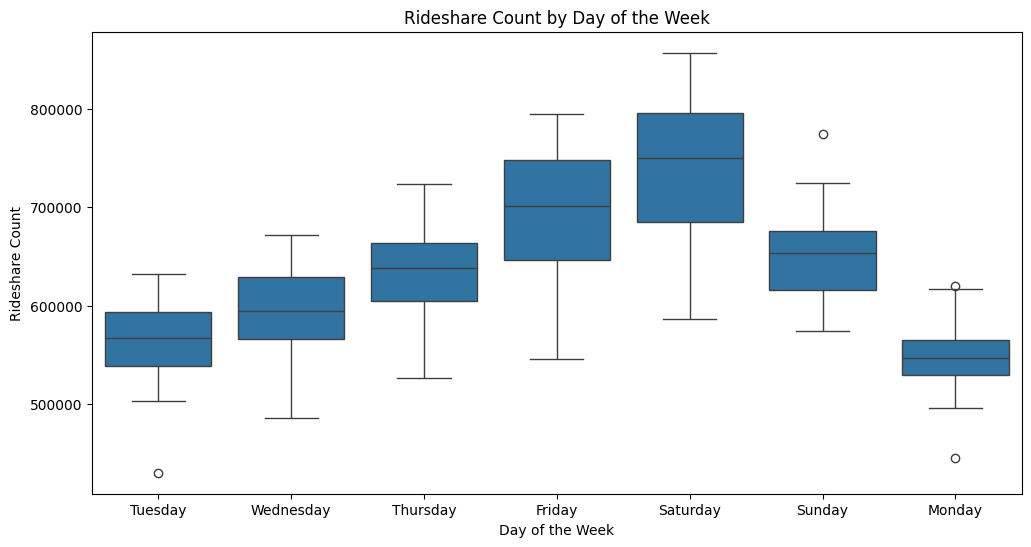

24/08/25 11:34:18 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 655340 ms exceeds timeout 120000 ms
24/08/25 11:34:18 WARN SparkContext: Killing executors is not supported by current scheduler.
24/08/25 11:34:24 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [20]:


# Rideshare count by day of the week
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='count', data=pandas_daily_rideshare )
plt.title('Rideshare Count by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Rideshare Count')
plt.show()


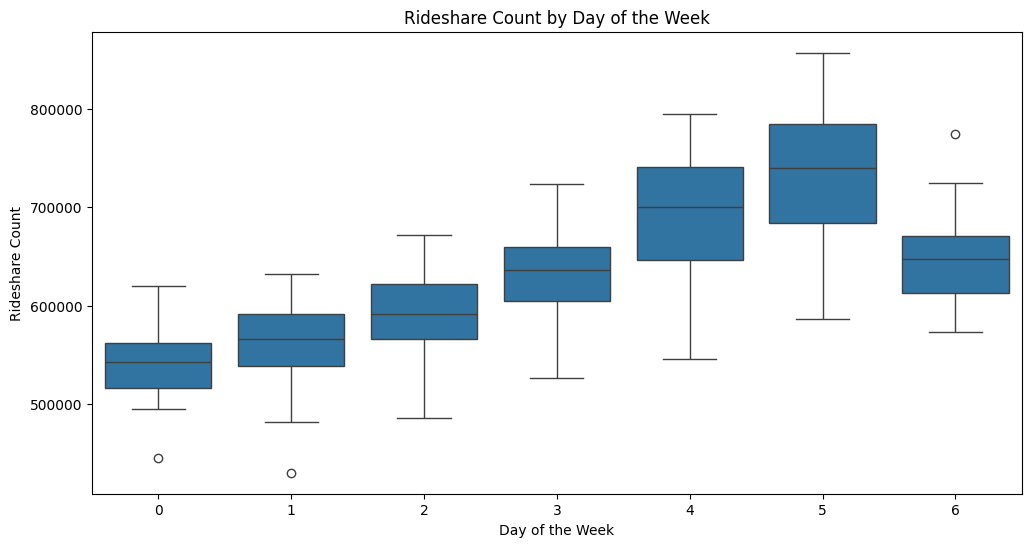

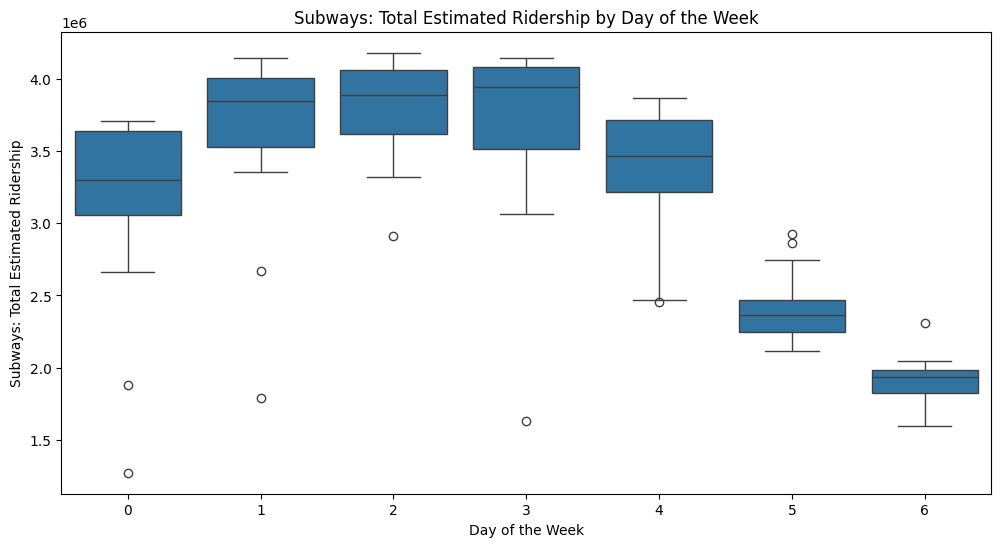

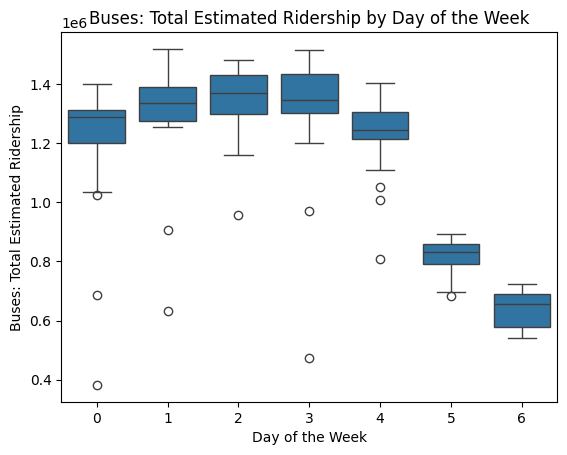

In [ ]:
# Rideshare count by day of the week
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='count', data=combined_df)
plt.title('Rideshare Count by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Rideshare Count')
plt.show()

# Ridership by day of the week
plt.figure(figsize=(12, 6))
for column in ['Subways: Total Estimated Ridership', 'Buses: Total Estimated Ridership']:
    sns.boxplot(x='day_of_week', y=column, data=combined_df)
    plt.title(f'{column} by Day of the Week')
    plt.xlabel('Day of the Week')
    plt.ylabel(column)
    plt.show()

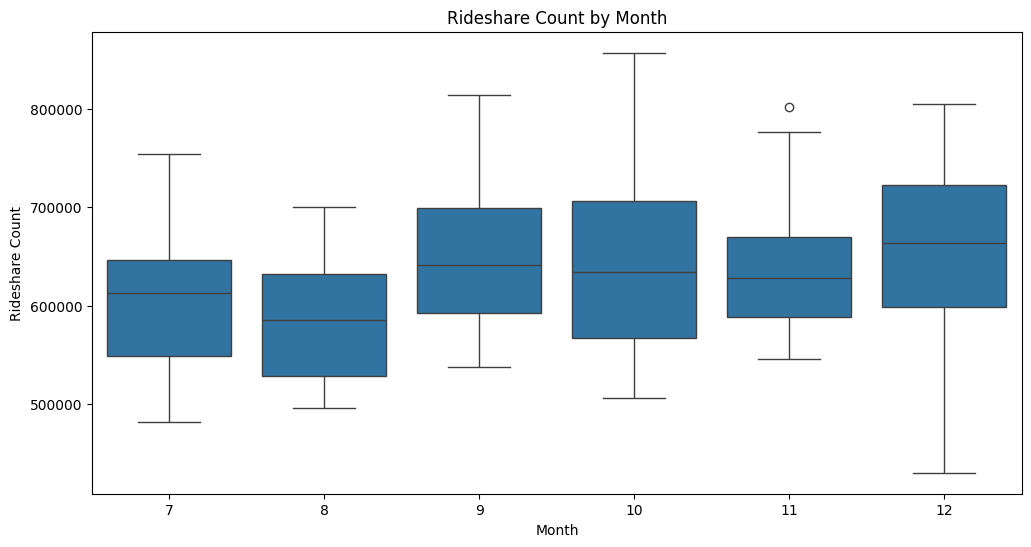

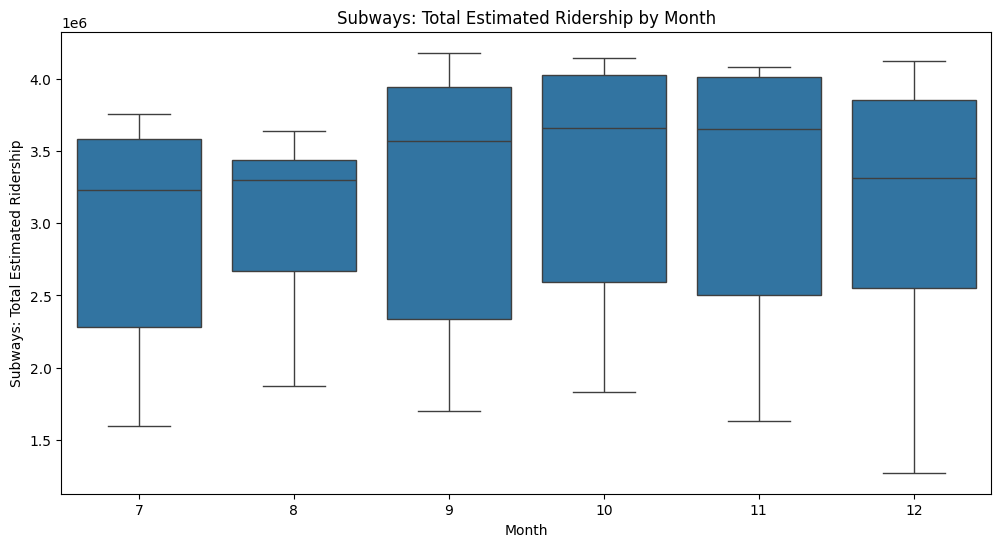

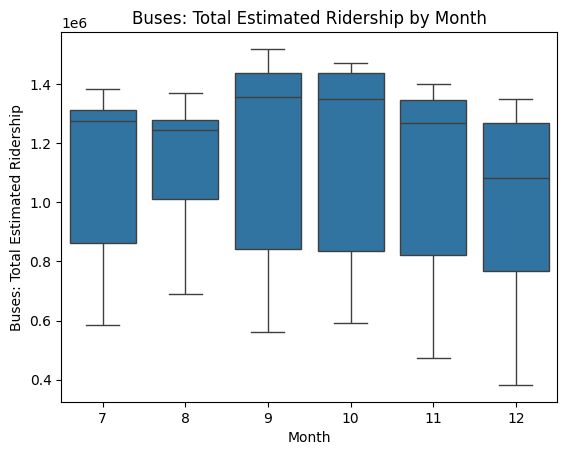

In [ ]:
# Rideshare count by month
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='count', data=combined_df)
plt.title('Rideshare Count by Month')
plt.xlabel('Month')
plt.ylabel('Rideshare Count')
plt.show()

# Ridership by month
plt.figure(figsize=(12, 6))
for column in ['Subways: Total Estimated Ridership', 'Buses: Total Estimated Ridership']:
    sns.boxplot(x='month', y=column, data=combined_df)
    plt.title(f'{column} by Month')
    plt.xlabel('Month')
    plt.ylabel(column)
    plt.show()

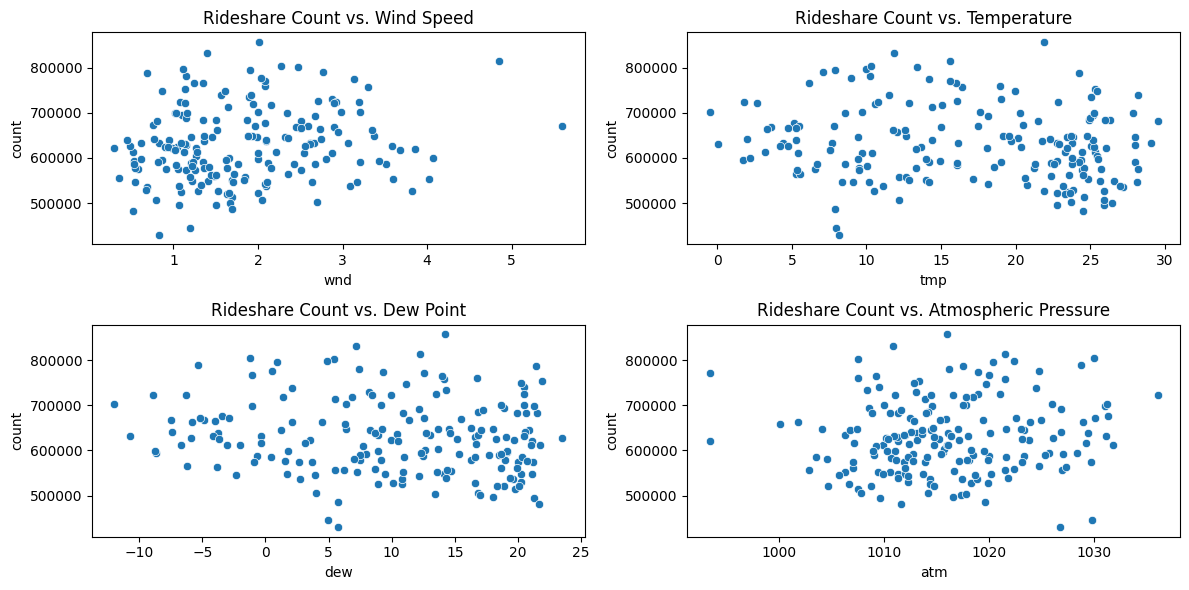

In [ ]:
# Plot weather variables
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.scatterplot(x='wnd', y='count', data=combined_df)
plt.title('Rideshare Count vs. Wind Speed')

plt.subplot(2, 2, 2)
sns.scatterplot(x='tmp', y='count', data=combined_df)
plt.title('Rideshare Count vs. Temperature')

plt.subplot(2, 2, 3)
sns.scatterplot(x='dew', y='count', data=combined_df)
plt.title('Rideshare Count vs. Dew Point')

plt.subplot(2, 2, 4)
sns.scatterplot(x='atm', y='count', data=combined_df)
plt.title('Rideshare Count vs. Atmospheric Pressure')

plt.tight_layout()
plt.show()

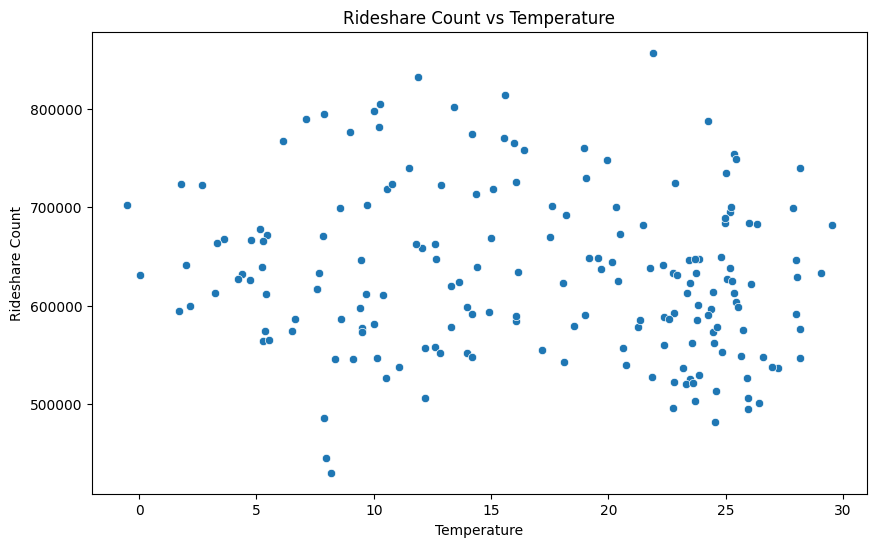

In [ ]:
# Scatter plot of rideshare count vs. temperature
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tmp', y='count', data=combined_df)
plt.title('Rideshare Count vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Rideshare Count')
plt.show()

In [ ]:
pandas_rideshare.describe()
pandas_ridership.describe()
pandas_weather.describe()

,wnd,tmp,dew,atm
count,184.000000,184.000000,184.000000,184.000000
mean,1.844324,16.823970,9.860315,1016.095297
std,0.934883,7.915783,8.854084,7.491355
min,0.300000,-0.512500,-11.975000,993.362500
25%,1.137500,10.015000,3.620750,1011.137500
50%,1.679167,18.079167,10.906250,1015.291667
75%,2.497917,23.867708,17.806250,1020.578125
max,5.600000,29.512500,23.508333,1036.100000
